# jif3D Tutorial 2 -- create a magnetic data file, model and run an inversion

In this tutorial we create a file with total field magnetic anomaly data for the same region as the previous gravity data. We then create an inversion mesh compatible with the gravity mesh and perform an individual inversion of the magnetic data. This is the second step towards performing a joint inversion. It is very important to get a good understanding of each dataset before jointly inverting them. This helps to sort out issues with each dataset which are much more difficult to understand when dealing with several types of data simultaneously. The steps and file formats are very similar to the previous case. We will therefore not describe everything with the same amount of detail, but only focus on aspects that are different.

As before we import some python packages for dealing with numerical data and cartographic projections. The total field magnetic data are obtained from the magnetic anomaly map of the United States (https://mrdata.usgs.gov/magnetic/) down-sampled to 0.2 degree spacing and upward continued to 10,000 m to remove small local features. These steps have been performed externally as discussing these procedures would go to far here. The results of this processing have been stored in an ascii file in the format latitude,longitude,magnetic field anomaly in $nT$. We do not have error information in the file, so for now we assume a global error of $1 nT$. This is likely somewhat optimistic and ideally we would have more information on uncertainty. We will revisit this issue at the end when discussing the inversion results.

In [1]:
import numpy as np
from pyproj import Proj
from netCDF4 import Dataset
import matplotlib.pyplot as plt

#set up projection, has to be consistent with other datasets
myProj = Proj("+proj=utm +zone=10t, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
#read in ascii file with data
magdata = np.genfromtxt("mag_0.2.xyz")

#project measurement positions from lon/lat to UTM Easting/Northing
MeasY, MeasX = myProj(magdata[:,0], magdata[:,1])
# data are upward continued to 10,000 m above the surface
MeasZ = -10000.0 * np.ones(MeasX.shape) 
T = magdata[:,2]
#set data error to 1 nT 
dT = np.ones(T.shape)

As the final goal is to perform a joint inversion, we want the data to cover the same area as the gravity measurements. We therefore read in the measurement positions from the gravity data and determine the maximum and minimum along each axis. We will limit the magnetic data to the corresponding rectangular box.

In [3]:
#read in the measurement positions from the gravity data file from tutorial 1
grav_fh = Dataset("../Tutorial1/gravdata.nc", "r")
GMX = grav_fh.variables["MeasPosX"][:]
GMY = grav_fh.variables["MeasPosY"][:]
grav_fh.close()
#determine the indices in our magnetic dataset that fall into the box
ind = (MeasX > np.min(GMX)) & (MeasX < np.max(GMX)) & (MeasY > np.min(GMY)) & (MeasY < np.max(GMY))

Creating the magnetic data file in netCDF format follows exactly the same procedure as the gravity data file. The only differences are the names of the data fields (T for total field anomaly and dT for the corresponding error) and the units. Here we use nano Tesla (nT), i.e. we deviate from our strict SI convention employed elsewhere. As before we subtract the mean value from the magnetic data to reduce the influence of long wavelength anomalies at depth. 

We also print out the spacing between adjacent data points to get an idea of how far apart they are and how this relates to our inversion mesh. Compared to the gravity data, the magnetic data are a bit more densely spaced, but still on the same order as our inversion grid.

In [4]:
#print out the data spacing between the first two measurements, gives us a rough idea of what to expect.
print("Data spacing: ", np.sqrt((MeasX[0]-MeasX[1])**2+(MeasY[0]-MeasY[1])**2))
#remove mean from all measurements within selected area
mT = T[ind] - np.mean(T[ind])
#write netCDF file following the same approach as the gravity data
data_fh = Dataset("magdata.nc", "w")
nstat = MeasX[ind].size
statdim = data_fh.createDimension("StationNumber", nstat)
vmeasx = data_fh.createVariable("MeasPosX","f8",("StationNumber"))
vmeasx.units = "m"
vmeasx[:] = MeasX[ind]
vmeasy = data_fh.createVariable("MeasPosY","f8",("StationNumber"))
vmeasy.units = "m"
vmeasy[:] = MeasY[ind]
vmeasz = data_fh.createVariable("MeasPosZ","f8",("StationNumber"))
vmeasz.units = "m"
vmeasz[:] = MeasZ[ind]
vgz = data_fh.createVariable("T","f8",("StationNumber"))
vgz.units = "nT"
vgz[:] = mT
vdgz = data_fh.createVariable("dT","f8",("StationNumber"))
vdgz.units = "nT"
vdgz[:] = dT[ind]
data_fh.close()

Data spacing:  11907.946309635632


When performing a joint inversion with have to use meshes with identical geometries. We therefore read in the geometry of the density mesh and create our magnetic mesh with the same values. Taking this into consideration when performing individual inversions allows us to adjust the meshes during the individual runs and then directly use them for the joint inversion. We use an anomalous susceptibility of zero for our inversion startibng model.

In [5]:
#read in geometry of gravity inversion mesh
grav_fh = Dataset("../Tutorial1/start_grav.nc", "r")
GNo = grav_fh.variables["Northing_Origin"][:]
GEo = grav_fh.variables["Easting_Origin"][:]
GDo = grav_fh.variables["Depth_Origin"][:]
Northing = grav_fh.variables["Northing"][:]
Easting = grav_fh.variables["Easting"][:]
Depth = grav_fh.variables["Depth"][:]
grav_fh.close()
#Create a 3D array for susceptibility filled with zero.
nx = Northing.size
ny = Easting.size
nz = Depth.size
Susceptibility = np.zeros([nz,ny,nx])

With the geometry specified we can make a susceptibility starting mesh. This follows the recipe for the gravity mesh. Susceptibility is a dimensionless quantity, so the *units* meta-data entry for this variable is a single space character. 

In [6]:
model_fh = Dataset("start_mag.nc", "w")
Northdim = model_fh.createDimension("Northing", Northing.size)
Eastdim = model_fh.createDimension("Easting", Easting.size)
Depthdim = model_fh.createDimension("Depth", Depth.size)
         
vnorth = model_fh.createVariable("Northing","f8",("Northing"))
vnorth[:] = Northing[:]
vnorth.units = "m"

vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
vnorth_orig[:] = GNo
         
veast = model_fh.createVariable("Easting","f8",("Easting"))
veast[:] = Easting[:]
veast.units = "m"
veast_orig = model_fh.createVariable("Easting_Origin","f8")
veast_orig[:] = GEo
         
vdepth = model_fh.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
vdepth_orig[:] = GDo
         
vsus  = model_fh.createVariable("Susceptibility","f8",("Depth","Easting","Northing"))
vsus[:,:,:] = Susceptibility[:,:,:]
vsus.units = " "
model_fh.close()  

As before for the gravity mesh we plot the data and mesh extent together to make sure everything is working correctly.

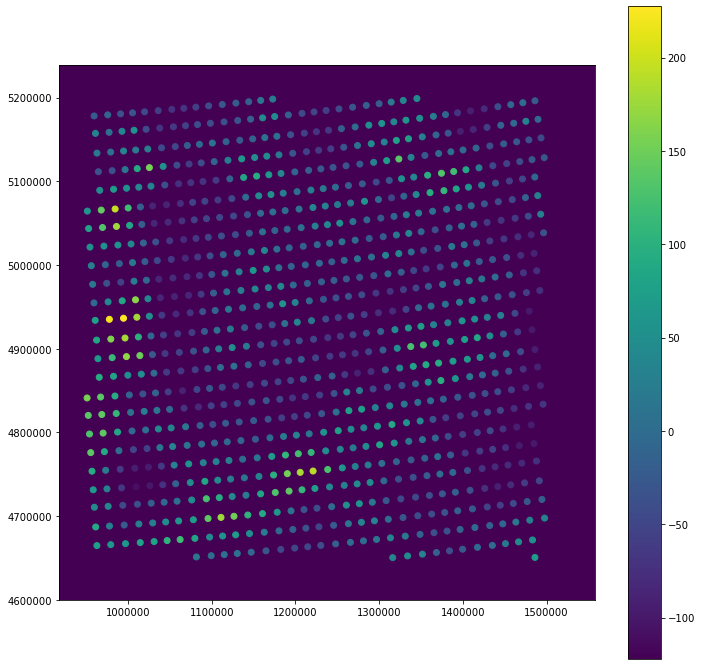

In [7]:
plt.figure(figsize=(12,12))
pn = np.append(GNo,Northing)
pe = np.append(GEo,Easting)
mx, my = np.meshgrid(pe,pn)
plt.pcolormesh(mx,my,np.transpose(Susceptibility[0,:,:]))
plt.scatter(MeasY[ind],MeasX[ind],c=mT)
plt.xlim([np.min(pe),np.max(pe)])
plt.ylim([np.min(pn),np.max(pn)])
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Running the inversion
As with the data and the mesh before, the basic approach to running the inversion is identical to the single gravity inversion. Obviously now we set the weight for gravity to zero and for magnetics to one. As a consequence the program expects the names for the mesh and data files in different positions. When running the program interactively on the command line this is easier to understand as the program specifies the type of files it expects. Looking carefully this can also be seen at the top of the output file.

For magnetic inversions we also have to specify the properties of the inducing field. For *jif3D* we describe this as a single set of inclination, declination (both in radian) and field-strenght in $nT$. It is assumed that these values are valid in the whole inversion domain which is a good approximation for regional surveys but can break down when the extent of the survey area becomes large. We can specify these values through options to the inversion program *grav_jointinv* (see options line below). A convenient tool to obtain the necessary values is the NOAA magnetic field calculator (https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm).

##Command line options
The concept of command line options is a common feature of the programs in jif3D. Running a program with the *--help* options will show the available options, their default values and a short description. Many aspects of the inversion can be customized this way. We will encounter a few more of these options in the next tutorials.

In [8]:
#location of the jif3D executables on your system
execpath = "/home/max/workspace/jif3D/bin/"
#program we want to run
progname = "grav_jointinv"
options = " --inclination 0.17 --declination 1.17 --fieldstrength 51184 "
#name of the susceptibility starting mesh
magmesh = "start_mag.nc"
#name of the magnetics data file
magdata = "magdata.nc"
#weight for standard gravity data, now zero because we want to invert magnetics
gravweight = 0.0
#weight for the magnetic data, set to 1 to invert magnetic data
magweight = 1.0
#weight for the FTG data, set to zero at the moment as we do not have FTG data 
ftgweight = 0
#weight for the density regularization, now zero because we do not have density
gravregularization = 0.0
#weight for susceptibility regularization, this now controls smoothness
magregularization = 100.0
# weight for the coupling term, zero as we perform only magnetic inversion
coupling = 0.0
#maximum number of iterations
iterations = 50
#write all information to file
f = open('run', 'w')
f.write(execpath+progname+options+" <<eof \n")    
f.write(magmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(str(magweight)+"\n")
f.write(magdata+"\n")
f.write(magmesh+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(coupling)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

Once we have specified the type of inversion, the files and weights, running the scripts works exactly as before.

In [9]:
import subprocess
outfile = open("jif3dmagout.out",'w')
subprocess.run(["bash ./run", ""],stdout=outfile,shell=True)
outfile.close()
log = open("jif3dmagout.out",'r')
for line in log:
    print(line)

Mesh filename: Scalar Gravimetry Lambda: FTG Lambda: Magnetics Lambda: Total field magnetic Data Filename: Magnetics Model Filename:  Magnetics ndata: 830

 Magnetics lambda: 1

Gravity Regularization Lambda: Magnetics Regularization Lambda: Cross-gradient weight: Performing inversion.

Maximum number of iterations:        Magnetics           MagReg 

     1.20219e+06                0 

Runtimes: 

              29                0 



Iteration: 0

       Magnetics           MagReg 

     1.20219e+06                0 

Runtimes: 

               0                0 



Individual Grad Norms: 

          965617                0 

Runtimes: 

               1                0 



       Magnetics           MagReg 

          964711          0.36359 

Runtimes: 

               0                0 



Individual Grad Norms: 

     1.10784e+06          1.54999 

Runtimes: 

               1                0 







Iteration: 1

       Magnetics           MagReg 

          500045         0

To get an impression of the inversion result we again plot the raw $\chi^2$ misfit, the RMS and the model roughness. We have specified a larger number of iterations (50, see if you can spot it where we create the run file for the inversion) as the inversion seems to converge a bit slower (or our assumed error of 1 nT is a bit too optimistic). 

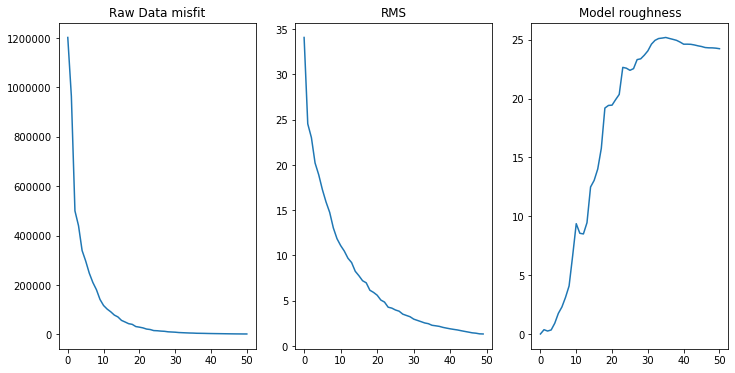

In [13]:
misfit = np.genfromtxt("misfit.out")
rms = np.genfromtxt("rms.out")
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(misfit[:,2])
plt.title("Raw Data misfit")
plt.subplot(132)
plt.plot(rms[:,1])
plt.title("RMS")
plt.subplot(133)
plt.plot(misfit[:,3])
plt.title("Model roughness")
plt.show()

Again we plot a horizontal slice and a vertical slice in East-West through the model. To first order the structures look quite different. While the gravity model is dominated by the banana shaped Snake River plane, the magnetic model shows south-west north-east trending structures. It will be interesting to see if the joint inversion can reconcile these models. 

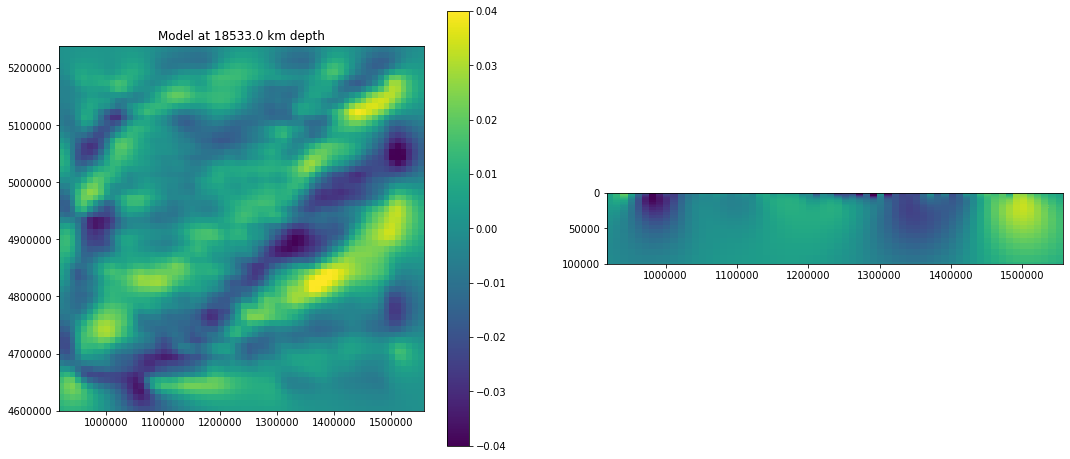

In [26]:
#the index of horizontal layer we want to plot, larger numbers = deeper, maximum 29 (nz-1)
depthindex = 10
#the index of the East-West slice, larger numbers = further north, maximum 63 (nx-1)
northindex = 32
#read in inversion model
mag_fh = Dataset("result.mag.inv.nc")
invsus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()
plt.figure(figsize = (18,8))
plt.subplot(121)
mx, my = np.meshgrid(pe,pn)
psus = np.transpose(invsus[depthindex,:,:])

plt.pcolormesh(mx,my,psus,vmin=-0.04,vmax=0.04)
plt.title("Model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()

plt.subplot(122)
pd = np.append(GDo,Depth)
mx, my = np.meshgrid(pe,pd)
plt.pcolormesh(mx,my,invsus[:,:,northindex],vmin=-0.04,vmax=0.04)
plt.ylim([100000,0])
plt.gca().set_aspect(1)
plt.show()

As with the gravity data we compare the observed and predicted data and their differences. In contrast to the previous inversion, this model produces some differences. These are not immediately visible when plotting observed and predicted data, but appear when we plot the difference (note the different color scales though).

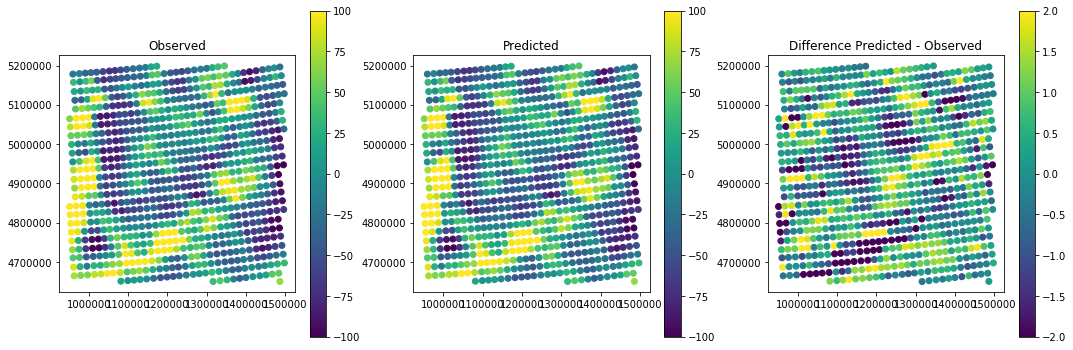

In [24]:
#Read in data calculated from the final model
invdata_fh=Dataset("result.inv_mag.nc")
invT = invdata_fh.variables["T"][:]
invdata_fh.close()

Tdiff = (invT-mT)
plt.figure(figsize = (18,6))
plt.subplot(131)
plt.scatter(MeasY[ind],MeasX[ind],c=mT,vmin=-100,vmax=100)
plt.gca().set_aspect(1)
plt.title("Observed")
plt.colorbar()
plt.subplot(132)
plt.scatter(MeasY[ind],MeasX[ind],c=invT,vmin=-100,vmax=100)
plt.colorbar()

plt.gca().set_aspect(1)
plt.title("Predicted")
plt.subplot(133)
plt.scatter(MeasY[ind],MeasX[ind],c=Tdiff,vmin=-2.0,vmax=2.0)
plt.colorbar()
plt.gca().set_aspect(1)
plt.title("Difference Predicted - Observed")
plt.show()

To look a little bit further in the characteristics of the misfit we can plot a histogram of the differences (see below). We can see that the large majority of difference values lies in a narrow range ($<\pm 5 nT$) symmetrically around zero, a sign of a generally good fit. However, there are a few values that show deviations of more than 10 nT and in all cases the observed data are larger than the modelled (negative Tdiff, look at the definition above). This can be a sign of isolated problematic data points.

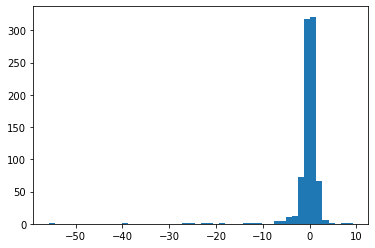

In [19]:
plt.figure()
plt.hist(Tdiff,bins=50)
plt.show()

We can identify the points with a deviation larger than 10 nT and plot them on the map. There is some spatial continuity, so it is possible that they are associated with the edge of some structures. However, some closer investigation would be useful to see what they are related (for example plotting on a geological map, looking at the original magnetic data). This is beyond the scope of this tutorial.

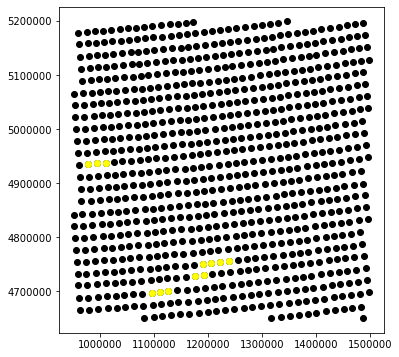

In [33]:
#All the measurement positions used in the inversion
mxi = MeasX[ind]
myi = MeasY[ind]
# find the indices of points with a difference greater than 10nT
problem = np.abs(Tdiff) > 10.0
plt.figure(figsize = (18,6))
#plot all measurement points in black
plt.scatter(myi,mxi,c='black')
#plot the problematic ones in yellow
plt.scatter(myi[problem],mxi[problem],c='yellow')
plt.gca().set_aspect(1)

plt.show()

## Tasks

- Change the regularization weight for the inversion to values between 1 and 100,000 (by a factor of ten) and observe how the data fit and the model change
- Change the values for depthindex and northindex in the model plot script and look how the models change with depth and from south to north.
- Optional: Download the final .vtk model file *result.grav.inv.vtk*, load it into paraview and investigate the model there 